In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from train_model import train

In [2]:
# getting data
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
from data_preprocessing import get_dataset


data, vocab = get_dataset(path_to_data)
train_data, valid_data, test_data = data
src_vocab, trg_vocab = vocab
PAD_IDX = trg_vocab.stoi['<pad>']


def _len_sort_key(x):
    return len(x.src)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_iterators(train_data=train_data, 
                  valid_data=valid_data,
                  test_data=test_data,
                  batch_size=512):


    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = batch_size, 
        device = device,
        sort_key=_len_sort_key
    )
    return train_iterator, valid_iterator, test_iterator

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9233
Unique tokens in target (en) vocabulary: 6741


In [57]:
import base_line_model
train_iterator, val_iterator, test_iterator = get_iterators()
baseline = base_line_model.get_model(len(src_vocab), len(trg_vocab))

In [58]:
import seq_to_seq_with_Attention_LSTM

train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=128)
ss_attent_lstm = seq_to_seq_with_Attention_LSTM.get_model(len(src_vocab), len(trg_vocab))

In [6]:
%load_ext autoreload
%autoreload seq_to_seq_with_Attention_GRU

In [16]:
import seq_to_seq_with_Attention_GRU___

train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=128)
ss_attent_gru = seq_to_seq_with_Attention_GRU___.get_model(len(src_vocab), len(trg_vocab))

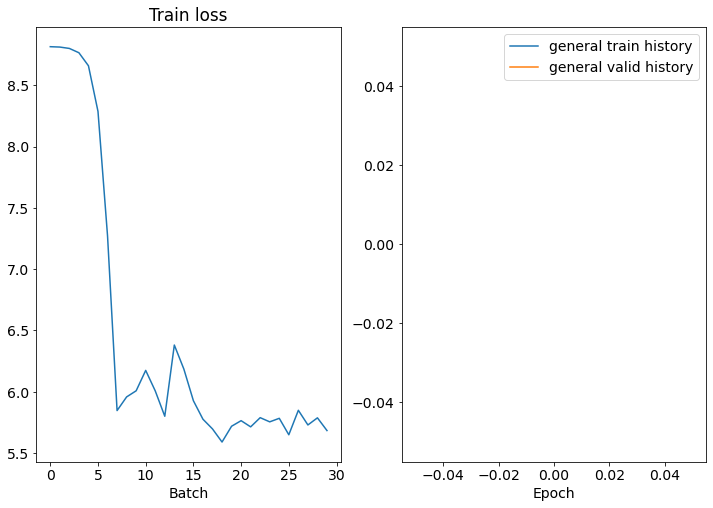

KeyboardInterrupt: 

In [17]:
%%time
optimizer = optim.Adam(ss_attent_gru.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train(ss_attent_gru, "seq_to_seq_Attention_LSTM", train_iterator, 
     valid_iterator, optimizer, criterion, n_epochs = 1)